# Final Project
## UCSC Extension DBDA.X425
## Author: Jammy Chan
## Date: 6/2/2020

<img src="https://www.komar.de/en/media/catalog/product/cache/5/image/9df78eab33525d08d6e5fb8d27136e95/8/-/8-487_star_wars_intro_ma.jpg">
<div style="background-color:black;color:white;padding:40px">
  <P style="font-size:40px;text-align:center">Image Classification on StarWars Fighter Ships</P>
</div>


# Introduction
Image classification is a common and interesting problem to solve. Instead of classifying common objects like cats/dogs or different kind of fruits, it would be interesting to classify some special objects - fighter ships from StarWars movies.

# Data Source
- Static images from Google Image Extractor (https://pypi.org/project/google-image-extractor/).
- Image Extraction From Video. Use OpenCV still picture extraction using frame-by-frame.


# Various types of StarWars fighter ships

<table style="margin-left:100px">
  <tr>
    <th style="text-align:center;font-size:18px">Fighter Ship Name</th>
    <th style="text-align:center;font-size:18px">Sample Pictures</th> 
    <th style="text-align:center;font-size:18px"></th> 
  </tr>
  <tr style="height:100px">
    <td style="text-align:center;font-size:16px">T65 Xwing Fighter</td>
    <td><img src="https://lumiere-a.akamaihd.net/v1/images/X-Wing-Fighter_47c7c342.jpeg?region=0%2C1%2C1536%2C864" width="300" height="300"></td>    
  </tr>
  <tr style="height:100px">
    <td style="text-align:center;font-size:16px">Naboo N1 Fighter</td>
    <td><img src="https://lumiere-a.akamaihd.net/v1/images/databank_naboon1starfighter_01_169_26691adf.jpeg?region=0%2C0%2C1560%2C878&width=1536" width="300" height="300"></td>    
  </tr>    
  <tr style="height:100px">
    <td style="text-align:center;font-size:16px">Tie Fighter</td>
    <td><img src="https://lumiere-a.akamaihd.net/v1/images/TIE-Fighter_25397c64.jpeg?region=0%2C1%2C2048%2C1152&width=1536" width="300" height="300"></td>
    <td><img src="https://lumiere-a.akamaihd.net/v1/images/vaders-tie-fighter_8bcb92e1.jpeg?region=0%2C147%2C1560%2C878&width=1536" width="300" height="300"></td>    
  </tr>    
  <tr style="height:100px">
    <td style="text-align:center;font-size:16px">Millenium Falcon</td>
    <td><img src="https://vignette.wikia.nocookie.net/starwars/images/2/21/MF_over_Takodana_SWCT.png/revision/latest?cb=20170605041002" width="300" height="300"></td>    
  </tr>    
  <tr style="height:100px">
    <td style="text-align:center;font-size:16px">Star Destroyer</td>
    <td><img src="https://lumiere-a.akamaihd.net/v1/images/Star-Destroyer_ab6b94bb.jpeg?region=0%2C0%2C1600%2C900&width=1536" width="300" height="300"></td> 
    <td><img src="https://lumiere-a.akamaihd.net/v1/images/databank_superstardestroyer_01_169_d5757b90.jpeg?region=0%2C0%2C1560%2C878&width=1536" width="300" height="300"></td>       
  </tr>
  <tr style="height:100px">
    <td style="text-align:center;font-size:16px">Jedi Fighter</td>
    <td><img src="https://lumiere-a.akamaihd.net/v1/images/ETA-2-starfighter-main-image_bedd3aaa.jpeg?region=232%2C0%2C1451%2C816" width="300" height="300"></td> 
    <td><img src="https://lumiere-a.akamaihd.net/v1/images/delta-7-starfighter_fe9a59bc.jpeg?region=0%2C304%2C1560%2C873&width=1536" width="300" height="300"></td>    
  </tr>
</table>

## General Image Viewer Class

In [1]:
import os, cv2, glob 
import re
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

class imageViewer:
    def display_random_image(self, class_names, images, labels, size):
        fig, a = plt.subplots(1, size, figsize=(12,3))
        fig.suptitle('Display %d random images from data pool' % size)
        cnt = 0
        for s in range(size):
            index = np.random.randint(images.shape[0])
            a[cnt].imshow(images[index])
            a[cnt].set_xticks([])
            a[cnt].set_yticks([])
            a[cnt].set_title(class_names[labels[index]])
            cnt += 1
        plt.show()
        
    def display_predicted(self, class_names, test_images, test_labels):    
        fig = plt.figure(figsize=(9,9))
        fig.suptitle("Examples of predicted images", fontsize=16)
        for i in range(25):
            plt.subplot(5,5,i+1)
            index = np.random.randint(test_labels.shape[0])
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(test_images[index], cmap=plt.cm.binary)
            plt.xlabel(class_names[test_labels[index]])
        plt.show()
        
    def display_mislabeled(self, class_names, test_images, test_labels, pred_labels):
        miss = (test_labels == pred_labels)
        mislabeled_indices = np.where(miss == 0)
        mislabeled_images = test_images[mislabeled_indices]
        mislabeled_labels = pred_labels[mislabeled_indices]
        title = "Example of mislabeled images by the classifier:"
        self.display_predicted(class_names, mislabeled_images, mislabeled_labels)

/usr/local/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Data Preprocessing Class

In [2]:
# Data preprocessing class
class SWPreprocess:
    def __init__(self, image_size, root_folder):
        images = []
        labels = []
        self.class_name = ['stardestroyer', 'xwing', 'tiefighter', 'mfalcon', 'naboofighter', 'jedifighter']
        self.class_map = {k : i for (i, k) in enumerate(self.class_name)}
        print("Load and resize images based on size [", image_size, "]\n")
        for r in root_folder:
            for folder in os.listdir(r):
                if re.search(r'.DS_Store', folder):
                    continue 
                label = self.class_map[folder]
                print("Image data path: [%s]" % r)
                # Iterate through each image in our folder
                print("Extract/Resize StarWars ship picture samples: [%s]" % folder)
                for file in tqdm(os.listdir(os.path.join(r, folder))):     
                    # Get the path name of the image
                    img_path = os.path.join(os.path.join(r, folder), file)
                    if re.search(r'.DS_Store', img_path):
                        continue
        
                    # Open and resize the img
                    try:
                        image = cv2.imread(img_path)
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                        image = cv2.resize(image, image_size) 
                    except:
                        print("Unable to process image:", img_path)
                
                    # Append the image and its corresponding label to the output
                    #images_sample[label].append(image)
                    images.append(image)
                    labels.append(label)
  
        # flattern python list to numpy array
        self.image_data = np.array(images, dtype = 'float32')
        self.label_data = np.array(labels, dtype = 'int32') 

    def displayTrainTestDistributions(self, y_train, y_test): 
        n_train = y_train.shape[0]
        n_test = y_test.shape[0]
        n_val = y_val.shape[0]

        print ("Number of training examples: {} (val: {})".format(n_train, n_val))
        print ("Number of testing examples: {}".format(n_test))

        import pandas as pd

        _, train_counts = np.unique(y_train, return_counts=True)
        _, test_counts = np.unique(y_test, return_counts=True)
        pd.DataFrame({'train': train_counts, 'test': test_counts}, index=self.class_name).plot.bar()
        plt.show()

    def displayClassDistributions(self, plt, type, count):
        plt.pie(count,
            explode=np.zeros(len(self.class_name)), 
            labels=self.class_name,
            autopct='%1.1f%%')
        plt.set_title('Proportion of class in %s set' % type)
        
    def prepareTrainTestSets(self):
        from sklearn.utils import shuffle
        from sklearn.model_selection import train_test_split

        X, y = shuffle(self.image_data, self.label_data, random_state=1234)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
        
        # split 90/10 for train/validation sets
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1234)
        # normal data scaling
        X_train = X_train / 255.0 
        X_test = X_test / 255.0
        X_val = X_val / 255.0
        
        print("Train: {}:{}, Validation: {}:{}, Test: {}:{}".format(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape,y_test.shape))
        return X_train, y_train, X_val, y_val, X_test, y_test
    

## Neural Network Model Class

In [3]:
# CNN model class
class SWModel:
    def __init__(self, imagesize, num_classes, model=None):
        self.cnn_model = self.initializeModel(model, num_classes, imagesize)
        print(self.cnn_model.summary())
        
    def initializeModel(self, model, num_classes, imagesize):
        if model == 'vgg16':
            baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=(None, None, 3)))
            # avoid model weight retrain to speed up fitting process
            baseModel.trainable = False
            return tf.keras.Sequential([
                baseModel,
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dense(num_classes, activation='softmax')
            ])            
            
        elif model == 'mobilenetv2':
            # use variable RGB image input
            baseModel = tf.keras.applications.MobileNetV2(input_tensor=tf.keras.Input(shape=(None, None, 3)), include_top=False, weights='imagenet')
            # avoid model weight retrain to speed up fitting process
            baseModel.trainable=False
            return tf.keras.Sequential([
                baseModel,
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.GlobalAveragePooling2D(),
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer='l2')
            ])
        
        else:
            # custom CNN model
            return tf.keras.Sequential([
                tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (imagesize[0], imagesize[1], 3)),
                tf.keras.layers.MaxPooling2D(2,2), # reduce neurons by half
                tf.keras.layers.Dropout(0.3),
                tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
                tf.keras.layers.MaxPooling2D(2,2), # reduce neurons by half
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(128, activation='relu', kernel_regularizer='l2'),
                #tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(num_classes, activation='softmax')     
            ])
    
    def compileFitModel(self, X_train, y_train, bsize, epochs, X_val, y_val):
        # applied EarlyStopping technique to avoid model overfit
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='auto', patience=5)
        self.cnn_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
        self.history = self.cnn_model.fit(X_train, y_train, verbose=1, batch_size=bsize, epochs=epochs, validation_data = (X_val, y_val), callbacks=[callback])

    def compileFitModel_IDG(self, X_train, y_train, bsize, epochs, X_val, y_val):
        #opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
        callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', mode='auto', patience=5)
        self.cnn_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
        # define train and validation generators
        
        t_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            rotation_range = 90,
            width_shift_range = 0.2,
            height_shift_range = 0.2,
            shear_range = 0.2,
            zoom_range = 0.2,
            horizontal_flip = True,
            vertical_flip = True,
            fill_mode = 'nearest')
        
        train_generator = t_gen.flow(X_train, y_train, batch_size=bsize, shuffle=True)
        self.history = self.cnn_model.fit_generator(train_generator, validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train)//bsize, verbose=1, epochs=epochs, callbacks=[callback])
        
    def plot_accuracy_loss(self):
        # plot accuracy/loss for both train and validation data sets
        fig = plt.figure(figsize=(10,5))

        # Plot accuracy
        plt.subplot(221)
        plt.plot(self.history.history['accuracy'],'bo--', label = "acc")
        plt.plot(self.history.history['val_accuracy'], 'ro--', label = "val_acc")
        plt.title("train_acc vs val_acc")
        plt.ylabel("accuracy")
        plt.xlabel("epochs")
        plt.legend()
        # Plot loss function
        plt.subplot(222)
        plt.plot(self.history.history['loss'],'bo--', label = "loss")
        plt.plot(self.history.history['val_loss'], 'ro--', label = "val_loss")
        plt.title("train_loss vs val_loss")
        plt.ylabel("loss")
        plt.xlabel("epochs")
        plt.legend()
        plt.show()

    def displayModelLayers(self):
        for idx,layer in enumerate(self.cnn_model.layers):
            print("[%d] [%s-T:%r] (%s) --> (%s)" %(idx, layer.name, layer.input_shape, layer.output_shape, layer.trainable))
            print("---------------------------")

    def display_confusion_matrix(self, class_names, y_test, y_pred):
        from sklearn.metrics import confusion_matrix
        import seaborn as sn
        CM = confusion_matrix(y_test, y_pred)
        ax = plt.axes()
        sn.heatmap(CM, annot=True, annot_kws={"size": 10}, xticklabels=class_names, yticklabels=class_names, ax = ax)
        ax.set_title('Confusion matrix of CNN Model')
        plt.show()

## Preprocessing StarWars image data
Start with image extraction using Google Image Extractor (https://pypi.org/project/google-image-extractor/). Try to extract up to 1000 images per class.

After that, cleaning image data and label each ship image folder accordingly ("starwars ships/google extractor"). However, it seems the number of valid images are around 300-500 images per class. Data size seems small but let's give it a try.

In [4]:
# Start gathering image data
default_image_size = (192, 192)
SWdata = SWPreprocess(default_image_size, ["starwars ships/google extractor"])

  2%|▏         | 6/369 [00:00<00:06, 56.71it/s]

Load and resize images based on size [ (192, 192) ]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [jedifighter]


  0%|          | 3/673 [00:00<00:38, 17.36it/s]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [stardestroyer]


  2%|▏         | 8/408 [00:00<00:05, 74.96it/s]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [naboofighter]


  1%|          | 3/568 [00:00<00:18, 29.82it/s]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [xwing]


  1%|          | 5/739 [00:00<00:18, 39.89it/s]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [mfalcon]


  1%|          | 5/743 [00:00<00:20, 36.53it/s]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [tiefighter]


100%|██████████| 743/743 [00:18<00:00, 40.52it/s]


In [5]:
# Prepare Train and test data sets.
# 80/20 Train/Test
# 90/10 Train/Validation
x_train, y_train, x_val, y_val, x_test, y_test = SWdata.prepareTrainTestSets()

Train: (2515, 192, 192, 3):(2515,), Validation: (280, 192, 192, 3):(280,), Test: (699, 192, 192, 3):(699,)


## Train/Test Distributions

Number of training examples: 2515 (val: 280)
Number of testing examples: 699


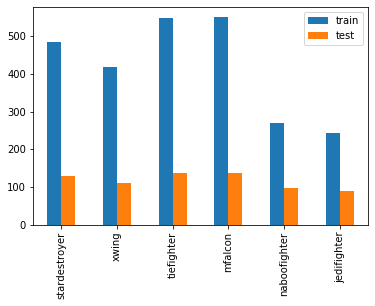

In [6]:
SWdata.displayTrainTestDistributions(y_train, y_test)

## Data Distributions among Classes
Data distribution for each class for train/test seems ok. No major data skew.

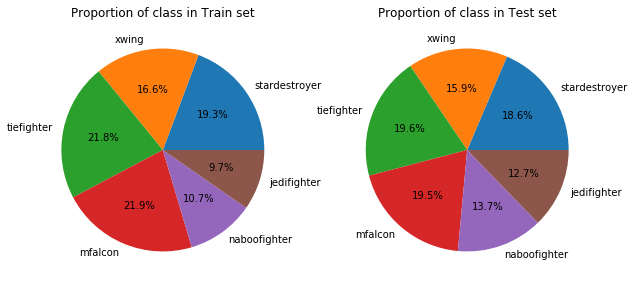

In [7]:
num_train_class, train_counts = np.unique(y_train, return_counts=True)
num_test_class, test_counts = np.unique(y_test, return_counts=True)

import matplotlib.pyplot as plt
fig,a =  plt.subplots(1,2, figsize=(10,10))

SWdata.displayClassDistributions(a[0], 'Train', train_counts)
SWdata.displayClassDistributions(a[1], 'Test', test_counts)
plt.show()

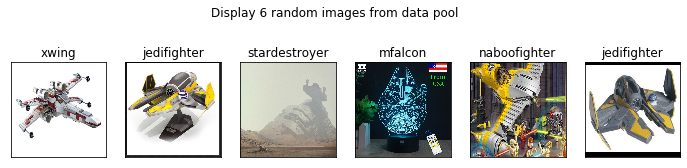

In [8]:
# Generate some sample random Star Wars images
imageViewer().display_random_image(SWdata.class_name, x_train, y_train, 6)

## Start with CNN model (Custom CNN)
Applied dropout layers and regularizations to reduce overfit.

In [9]:
model_cnn = SWModel(default_image_size, len(SWdata.class_name))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 95, 95, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 135424)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [10]:
# now compile and fit the model (~22 mins to train)
model_cnn.compileFitModel(x_train, y_train, 64, 30, x_val, y_val)

Train on 2515 samples, validate on 280 samples
Epoch 1/30
2515/2515 [==============================] - 50s 20ms/sample - loss: 6.4758 - accuracy: 0.2091 - val_loss: 3.0830 - val_accuracy: 0.4071
Epoch 2/30
2515/2515 [==============================] - 46s 18ms/sample - loss: 2.5034 - accuracy: 0.3495 - val_loss: 2.0244 - val_accuracy: 0.4607
Epoch 3/30
2515/2515 [==============================] - 53s 21ms/sample - loss: 1.8384 - accuracy: 0.5145 - val_loss: 1.7077 - val_accuracy: 0.5643
Epoch 4/30
2515/2515 [==============================] - 46s 18ms/sample - loss: 1.5886 - accuracy: 0.5857 - val_loss: 1.5142 - val_accuracy: 0.5571
Epoch 5/30
2515/2515 [==============================] - 46s 18ms/sample - loss: 1.4078 - accuracy: 0.6362 - val_loss: 1.6453 - val_accuracy: 0.5750
Epoch 6/30
2515/2515 [==============================] - 46s 18ms/sample - loss: 1.3503 - accuracy: 0.6767 - val_loss: 1.5576 - val_accuracy: 0.6429
Epoch 7/30
2515/2515 [==============================] - 45s 18ms/

In [11]:
model_cnn.cnn_model.evaluate(x_test, y_test)

699/699 [==============================] - 4s 5ms/sample - loss: 1.6946 - accuracy: 0.6237


[1.6946348724447096, 0.6237482]

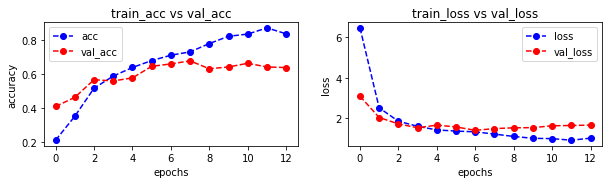

In [12]:
model_cnn.plot_accuracy_loss()

## Preliminary result
First CNN model (model_cnn) gives ~60% of accuracy is not too bad. The prediction accuracy depends on the amount of available data. As each class does not have large data set based on Google chrome extractor, use other method to extract more data.

## Image Extraction From Video
The idea is to extract still pictures from individual video frames. Use opencv2 to open the video and then saved frame-by-frame as jpg. At the end, there is a need to screen saved frames and store them to different figher ship folders accordingly ("starwars ships/video frame extractor")

In [13]:
def extractVideoFrame(videopath):
    vobj = cv2.VideoCapture(videopath)
    success = 1
    count = 0
    while success:
        success, image = vidobj.read()
        cv2.imwrite("vframe%d.jpg" % count, image)
        count += 1

In [14]:
# Start gathering image data again - including images from both still and from selected video frames
default_image_size = (192, 192)
SWdata = SWPreprocess(default_image_size, ["starwars ships/google extractor", "starwars ships/video frame extractor"])

  2%|▏         | 7/369 [00:00<00:05, 69.13it/s]

Load and resize images based on size [ (192, 192) ]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [jedifighter]


  0%|          | 3/673 [00:00<00:36, 18.31it/s]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [stardestroyer]


  2%|▏         | 8/408 [00:00<00:05, 77.69it/s]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [naboofighter]


  1%|          | 3/568 [00:00<00:19, 28.27it/s]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [xwing]


  1%|          | 6/739 [00:00<00:14, 52.08it/s]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [mfalcon]


  1%|          | 5/743 [00:00<00:21, 34.01it/s]

Image data path: [starwars ships/google extractor]
Extract/Resize StarWars ship picture samples: [tiefighter]


  2%|▏         | 30/1534 [00:00<00:05, 296.98it/s]

Image data path: [starwars ships/video frame extractor]
Extract/Resize StarWars ship picture samples: [jedifighter]


  1%|▏         | 12/957 [00:00<00:08, 111.36it/s]

Image data path: [starwars ships/video frame extractor]
Extract/Resize StarWars ship picture samples: [stardestroyer]


  1%|▏         | 26/2034 [00:00<00:07, 258.93it/s]

Image data path: [starwars ships/video frame extractor]
Extract/Resize StarWars ship picture samples: [naboofighter]


  1%|          | 11/1889 [00:00<00:17, 106.29it/s]

Image data path: [starwars ships/video frame extractor]
Extract/Resize StarWars ship picture samples: [xwing]


  1%|          | 12/1593 [00:00<00:13, 113.50it/s]

Image data path: [starwars ships/video frame extractor]
Extract/Resize StarWars ship picture samples: [mfalcon]


  1%|          | 12/1472 [00:00<00:12, 115.05it/s]

Image data path: [starwars ships/video frame extractor]
Extract/Resize StarWars ship picture samples: [tiefighter]


100%|██████████| 1472/1472 [00:11<00:00, 125.65it/s]


In [15]:
x_train, y_train, x_val, y_val, x_test, y_test = SWdata.prepareTrainTestSets()

Train: (9335, 192, 192, 3):(9335,), Validation: (1038, 192, 192, 3):(1038,), Test: (2594, 192, 192, 3):(2594,)


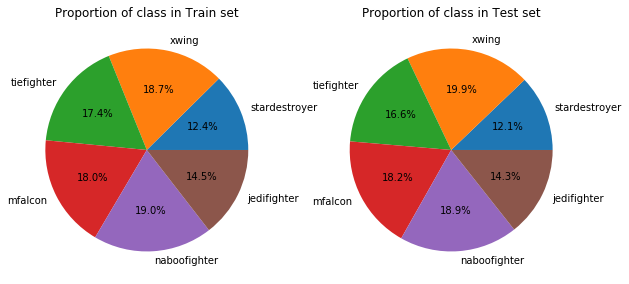

In [16]:
# Review the data distribution after applying new data
num_train_class, train_counts = np.unique(y_train, return_counts=True)
num_test_class, test_counts = np.unique(y_test, return_counts=True)

import matplotlib.pyplot as plt
fig,a =  plt.subplots(1,2, figsize=(10,10))

SWdata.displayClassDistributions(a[0], 'Train', train_counts)
SWdata.displayClassDistributions(a[1], 'Test', test_counts)
plt.show()

Number of training examples: 9335 (val: 1038)
Number of testing examples: 2594


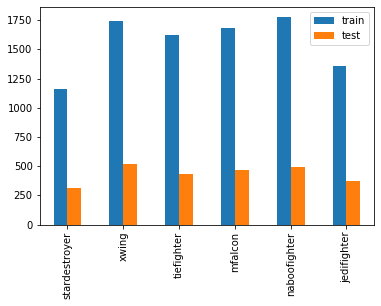

In [17]:
SWdata.displayTrainTestDistributions(y_train, y_test)

In [18]:
#reapply the same CNN model using the extended data set. (~1 hr to train)
model_cnn = SWModel(default_image_size, len(SWdata.class_name))
model_cnn.compileFitModel(x_train, y_train, 64, 30, x_val, y_val)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 135424)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [19]:
model_cnn.cnn_model.evaluate(x_test, y_test)

2594/2594 [==============================] - 14s 5ms/sample - loss: 1.0246 - accuracy: 0.8196


[1.0246244183207993, 0.81958365]

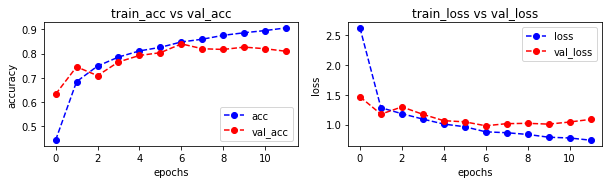

In [20]:
model_cnn.plot_accuracy_loss()

With applying ~4X of image data, the accuracy of the model increases from 60% to over 80%!!! The additional video frame data definitely helps.

## Model Comparison
Now, let's explore the classification using prebuild models. This apply the Model Transfer concept in neural networks. The idea is to leverage prebuild models that weights in neurons are optimized and should expect better performance. We will try both VGG16 and MobileNetV2.

## Transfer Learning with VGG16 (~6.5 hours)

In [21]:
model_vgg16 = SWModel(default_image_size, len(SWdata.class_name), 'vgg16')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, None, None, 512)   14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 3078      
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [22]:
model_vgg16.compileFitModel(x_train, y_train, 64, 30, x_val, y_val)

Train on 9335 samples, validate on 1038 samples
Epoch 1/30
9335/9335 [==============================] - 578s 62ms/sample - loss: 1.5042 - accuracy: 0.4937 - val_loss: 1.3037 - val_accuracy: 0.6435
Epoch 2/30
9335/9335 [==============================] - 1836s 197ms/sample - loss: 1.1383 - accuracy: 0.6902 - val_loss: 1.0728 - val_accuracy: 0.7119
Epoch 3/30
9335/9335 [==============================] - 567s 61ms/sample - loss: 0.9631 - accuracy: 0.7388 - val_loss: 0.9382 - val_accuracy: 0.7534
Epoch 4/30
9335/9335 [==============================] - 588s 63ms/sample - loss: 0.8528 - accuracy: 0.7680 - val_loss: 0.8423 - val_accuracy: 0.7669
Epoch 5/30
9335/9335 [==============================] - 735s 79ms/sample - loss: 0.7760 - accuracy: 0.7914 - val_loss: 0.7736 - val_accuracy: 0.7948
Epoch 6/30
9335/9335 [==============================] - 615s 66ms/sample - loss: 0.7162 - accuracy: 0.8042 - val_loss: 0.7197 - val_accuracy: 0.7967
Epoch 7/30
9335/9335 [==============================] - 

In [23]:
model_vgg16.cnn_model.evaluate(x_test, y_test)        

2594/2594 [==============================] - 194s 75ms/sample - loss: 0.3920 - accuracy: 0.8863


[0.39201796513248977, 0.886276]

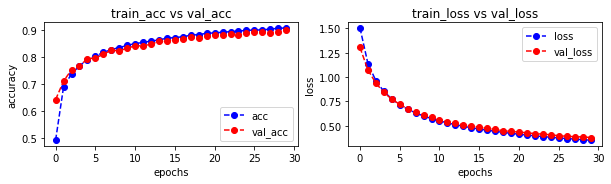

In [24]:
model_vgg16.plot_accuracy_loss()

## Transfer Learning with MobilenetV2 (Train < 1 hour)

In [25]:
model_mnetv2 = SWModel(default_image_size, len(SWdata.class_name), 'mobilenetv2')

/usr/local/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, None, None, 1280)  2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, None, None, 1280)  0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [26]:
model_mnetv2.compileFitModel(x_train, y_train, 64, 30, x_val, y_val)

Train on 9335 samples, validate on 1038 samples
Epoch 1/30
9335/9335 [==============================] - 192s 21ms/sample - loss: 0.9201 - accuracy: 0.7188 - val_loss: 0.7916 - val_accuracy: 0.7707
Epoch 2/30
9335/9335 [==============================] - 1504s 161ms/sample - loss: 0.5075 - accuracy: 0.8776 - val_loss: 0.7087 - val_accuracy: 0.8015
Epoch 3/30
9335/9335 [==============================] - 177s 19ms/sample - loss: 0.4465 - accuracy: 0.8972 - val_loss: 0.6760 - val_accuracy: 0.8160
Epoch 4/30
9335/9335 [==============================] - 177s 19ms/sample - loss: 0.4160 - accuracy: 0.9076 - val_loss: 0.6464 - val_accuracy: 0.8092
Epoch 5/30
9335/9335 [==============================] - 178s 19ms/sample - loss: 0.3968 - accuracy: 0.9149 - val_loss: 0.6053 - val_accuracy: 0.8285
Epoch 6/30
9335/9335 [==============================] - 179s 19ms/sample - loss: 0.3761 - accuracy: 0.9185 - val_loss: 0.6120 - val_accuracy: 0.8343
Epoch 7/30
9335/9335 [==============================] - 

In [27]:
model_mnetv2.cnn_model.evaluate(x_test, y_test)

2594/2594 [==============================] - 35s 14ms/sample - loss: 0.6590 - accuracy: 0.8150


[0.6590172943925526, 0.8149576]

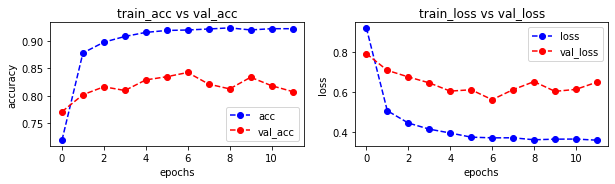

In [28]:
model_mnetv2.plot_accuracy_loss()

## Image Argumentation 
- Image argumentation - Use ImageDataGenerator to increase training data and variations
Increase training data set by rotate, transpose or transform images

In [29]:
model_cnn_arg = SWModel(default_image_size, len(SWdata.class_name))
model_cnn_arg.compileFitModel_IDG(x_train, y_train, 256, 30, x_val, y_val)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 190, 190, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 95, 95, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 95, 95, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 93, 93, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 135424)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)              

In [30]:
model_cnn_arg.cnn_model.evaluate(x_test, y_test)

2594/2594 [==============================] - 13s 5ms/sample - loss: 1.2084 - accuracy: 0.6507


[1.20844033537411, 0.65073246]

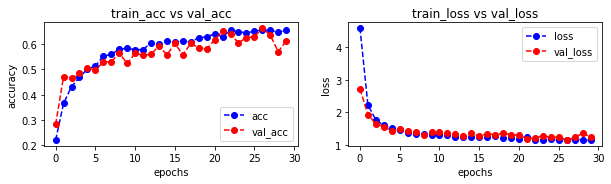

In [31]:
model_cnn_arg.plot_accuracy_loss()

In [32]:
predictions = model_cnn.cnn_model.predict(x_test)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

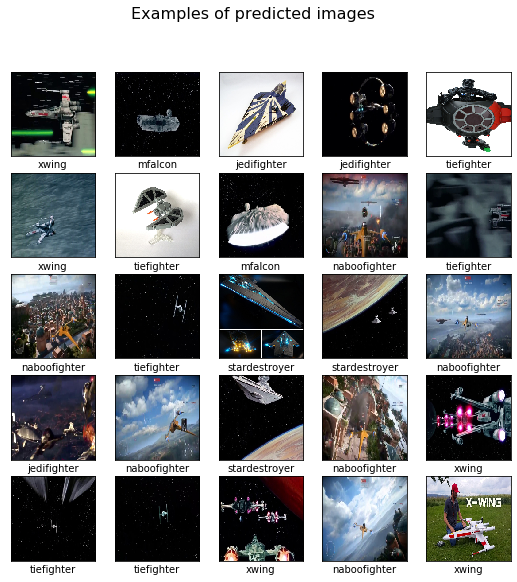

In [33]:
imageViewer().display_predicted(SWdata.class_name, x_test, y_test)

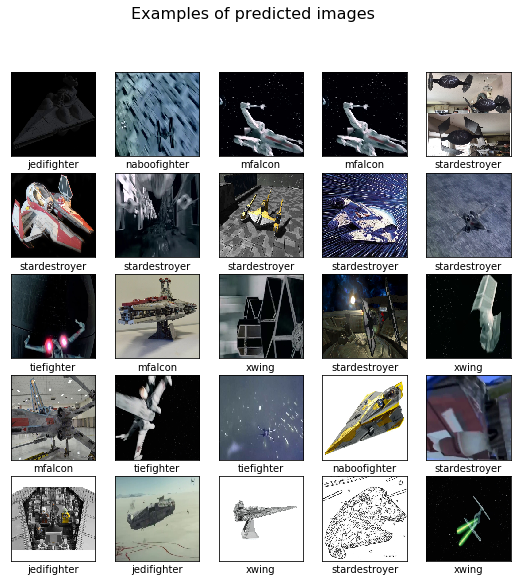

In [34]:
imageViewer().display_mislabeled(SWdata.class_name, x_test, y_test, pred_labels)

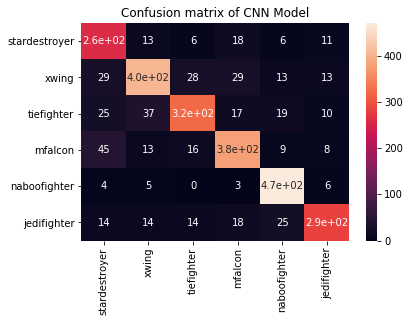

In [35]:
# Check confusion matrix for custom CNN model
model_cnn.display_confusion_matrix(SWdata.class_name, y_test, pred_labels)    

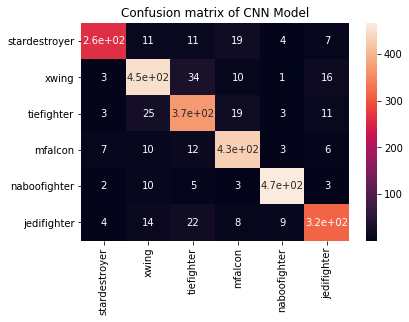

In [36]:
# Check confusion matrix for VGG16 model
predvgg16 = model_vgg16.cnn_model.predict(x_test)     # Vector of probabilities
predvgg16 = np.argmax(predvgg16, axis = 1) # We take the highest probability
model_vgg16.display_confusion_matrix(SWdata.class_name, y_test, predvgg16)  

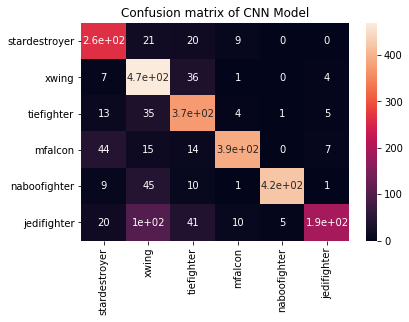

In [37]:
# Check confusion matrix for MobileNetV2 model
predmnetv2 = model_mnetv2.cnn_model.predict(x_test)     # Vector of probabilities
predmnetv2 = np.argmax(predmnetv2, axis = 1) # We take the highest probability
model_mnetv2.display_confusion_matrix(SWdata.class_name, y_test, predmnetv2)  

## Multiclass ROC Curve
To plot sensitivity (true positive) versus specificity (true negative) to measure the performance of the model.
Note that the plot is per binary class, there is a need to use binarizer or onevsrestclassifier to convert y_test values to have the dimension that match to the number of prediction classes. Let's use custom CNN model prediction data in this exercise.

In [43]:
def convMC(y_test):
    from sklearn import preprocessing
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    return lb.transform(y_test)

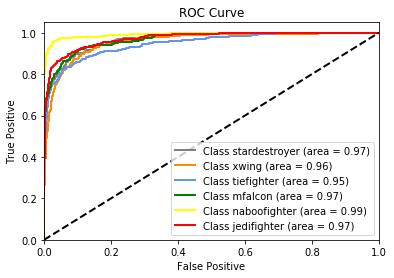

In [44]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0, len(SWdata.class_name)):
    fpr[i], tpr[i], _ = roc_curve(convMC(y_test)[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Plot all ROC curves
plt.figure(1)
colors = cycle(['grey', 'darkorange', 'cornflowerblue', 'green', 'yellow', 'red'])
for i, color in zip(range(0, len(SWdata.class_name)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Class {0} (area = {1:0.2f})'
             ''.format(SWdata.class_name[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

As illustrated, classification of naboofighter has the best ROC_AUC score and stardestroyer has the lowest compare to the rest of classes.

## Misclassification Analysis
To sample some of the misclassified groups, we extracted the probabilities (softmax) of each class.

In [48]:
miss = (y_test == pred_labels)
miss_index = np.where(miss == 0)
miss_images = x_test[miss_index]
miss_labels = pred_labels[miss_index]
miss_proba = predictions[miss_index]

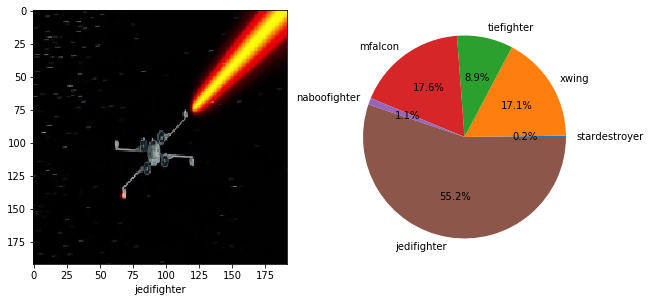

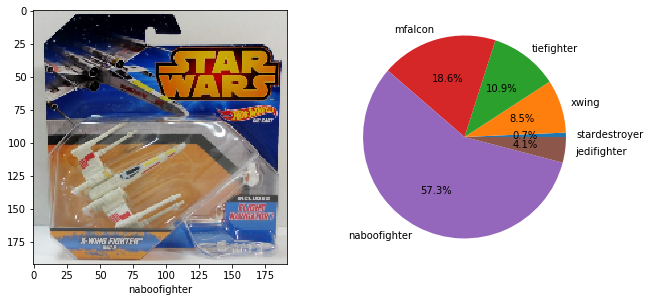

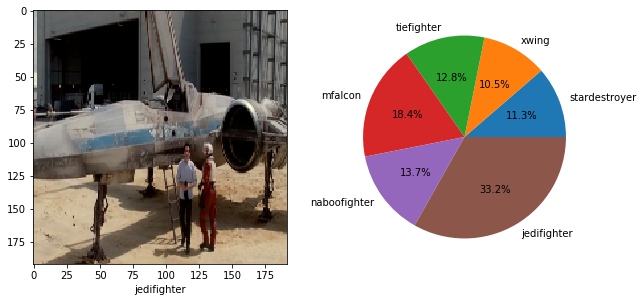

In [49]:
import matplotlib.pyplot as plt
# choose misclassified samples index 1, 2 and 5
for cindex in [1,2,5]:
    fig,a =  plt.subplots(1,2, figsize=(10,10))

    a[0].imshow(miss_images[cindex], cmap=plt.cm.binary)
    a[0].set_xlabel(SWdata.class_name[miss_labels[cindex]])
    a[1].pie(miss_proba[cindex], explode=np.zeros(len(SWdata.class_name)), labels=SWdata.class_name, autopct='%1.1f%%')
    plt.show()

## Conclusion

- Using traditional CNN networks are used to perform image classification.
- Pre-trained networks like VGG16 gives better accuracy (model weights are fine-tuned).
- Data size is one of the key factors for CNN model accuracy.
- Increase number of layers may increase accuracy of the model. However, it also introduces overfits. Model tuning like regularizations, dropouts or earlystopping are useful.


## Potential improvements
- Distinct features from each class image should be captured. Reductant features can be considered by feature reduction (e.g. Recursive Feature Selection (RFE), PCA)
- Other computer vision deep learning approaches (semantic segmentation (Unet), object detection (Yolo) etc.